# Trabalho de Conclusão de Curso
# Pós-graduação em Ciência de Dados e Big Data (2020) - PUC Minas
## Fábio Daros de Freitas
### Módulo preditor baseado em redes neurais

<font color='red'>
<h3>    
Versão disponibilizada no repositório como requisito da PUC-MG para entrega do TCC.<br>
Todos os dados sigilosos foram anonimizados, descaracterizados, <br>
e com valores nominais substituidos por z-scores, em conformidade com o sigilo fiscal dos dados.<br>
Consultar o texto do TCC para obter mais detalhes.     
</h3>    
</font>    

In [15]:
import sys
import os
tcc_dir = 'C:\REPO'
sys.path.append(tcc_dir)
if 'COMMON.tcc_common' in sys.modules:
    del sys.modules['COMMON.tcc_common']
from COMMON.tcc_common import *
print_md('**OK**')

import torch

Pandas version......: 0.24.2
Numpy version.......: 1.16.2
Scikit-learn version: 0.20.3
Seaborn version.....: 0.9.0
Stats models version: 0.9.0
Matplotlib version..: 3.0.3


**OK**

In [20]:
# Le dataset anonimizado, descaracterizado, e com valores z-scores ao inves dos valores nominais
fname=f'tcc_dataset_final_balanceado_descaracterizado.csv'
df = pd.read_csv(fname)    

In [21]:
# Importa modulos PyTorch
from numpy import vstack
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [22]:
# Neural Network class
'''
Network topology definition dictionary in the form:

topology = Dict()
topology.name            = f'Topology name used as abse filename for saving model parameters'
topology.layers          = 'inp :  64          : 32           : 2               :1'
topology.activations     = 'inp : relu         : relu         : sigmoid         : sigmoid'
topology.initializations = 'inp : kaiming_relu : kaiming_relu : kaiming_sigmoid : xavier'

'''
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, topology):
        super(MLP, self).__init__()
        torch.manual_seed(0)        
        self.layers = []
        self.activations = []
        # parse topology and activations
        print('Creating neural network:')        
        layers          = topology.layers.replace(' ', '').split(':')[1:]
        activations     = topology.activations.replace(' ', '').split(':')[1:]    
        initializations = topology.initializations.replace(' ', '').split(':')[1:] if 'initializations' in topology else None
        n_input = topology.input_size
        for i in range(len(layers)):            
            # layers
            n_output = int(layers[i])            
            print(f'-layer({i+1}): Linear({n_input:3d}, {n_output:3d})', end='\t')
            layer = torch.nn.Linear(n_input, n_output)
            setattr(self, f'layer{i}', layer) # necessary that the layer be a member of the class            
            self.layers.append(layer)
            
            # activations
            activation = activations[i]
            if activation == 'relu':
                print(f'activation {activation}', end='\t')
                self.activations.append(torch.relu)
            elif activation == 'sigmoid':
                print(f'activation {activation}', end='\t')                                                          
                self.activations.append(torch.sigmoid)
            
            # initializations
            if initializations is not None:
                initialization = initializations[i]
                if initialization == '':
                    print(f'no weights initialization', end='\t')                    
                if initialization.startswith('kaiming'):
                    nl = initialization.split('_')
                    if len(nl) == 1:
                        nonlinearity = 'relu'
                    if len(nl) == 2:
                        nonlinearity = initialization.split('_')[1]
                        torch.nn.init.kaiming_uniform_(getattr(self, f'layer{i}').weight, nonlinearity=nonlinearity)
                    else:
                        nonlinearity = None                        

                    if nonlinearity is None:
                        print(f'**ERROR*: {initialization} not in format kaiming_nonlinearity', end='\t') 
                    else:
                        torch.nn.init.kaiming_uniform_(getattr(self, f'layer{i}').weight, nonlinearity=nonlinearity)                                                
                        print(f'weights initialization kaiming_uniform_ {nonlinearity} ', end='\t')

                elif initialization.startswith('xavier'):
                    torch.nn.init.xavier_uniform_(getattr(self, f'layer{i}').weight)
                    print(f'weights initialization xavier_uniform_', end='\t')                                                                                                                              
            print('')            
            # next n_input
            n_input = n_output
        print('')

    # forward propagate input
    def forward(self, X):        
        for layer, activation in zip(self.layers, self.activations):                    
            X = activation(layer(X))                
        return X

    # reset all weights
    def reset_weights(self):
        #print(f'Reset all network trainable parameters')        
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                #print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()
                
# dataset definition
class DataSet(Dataset):
    # load the dataset
    def __init__(self, df):
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]        
        # ensure input data is floats
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.20):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])                

In [40]:
# Preditor baseado em Redes Neurais

# model_cross_validation() callback handlers:

# prepare the dataset for a single fold
def fold_data(df, trn_ids, tst_ids, fold, epochs, lr, momentum, verbose, plot):
    
    # preprocess features
    scaler       = StandardScaler()    
    cols         = df_columns_metric(df)
    feats        = scaler.fit_transform(df[cols])
    df[cols] = pd.DataFrame(feats, index=df.index, columns=cols)        
            
    # adjusts data types
    df['maed_dctf']       = df['maed_dctf'].astype(np.float64)
    df['maed_dctf_total'] = df['maed_dctf_total'].astype(np.float64)    
        
    # load the dataset
    dataset = DataSet(df)
    
    # Sample elements randomly from a given list of ids, no replacement.
    trn_subsampler = torch.utils.data.SubsetRandomSampler(trn_ids)
    tst_subsampler  = torch.utils.data.SubsetRandomSampler(tst_ids)
    
    # Define data loaders for training and testing data in this fold
    trn_dl = torch.utils.data.DataLoader(dataset, batch_size=100, sampler=trn_subsampler)
    tst_dl = torch.utils.data.DataLoader(dataset, batch_size=100, sampler=tst_subsampler)    
   
    return trn_dl, tst_dl    

# train the model
def train_model(model, trn_dl, tst_dl, fold, epochs, lr, momentum, verbose, plot):
    print(f'Training model during {epochs} epochs ...')

    losses = []
    accuracies  = []

    # Set model inits    
    torch.manual_seed(0)        
    model.reset_weights()
    
    # define the optimization
    criterion = BCELoss()
           
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    trn_metrics = PredResult(name='Train trn', index_name='epoch')
    tst_metrics = PredResult(name='Train tst', index_name='epoch')
    
    loss_trn = []
    
    # enumerate epochs    
    for epoch in range(epochs):
        
        # train mini-batches
        current_loss = []        
        count = 0
        
        for i, (inputs, targets) in enumerate(trn_dl):

            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            
            # update model weights
            optimizer.step()

            # Print statistics
            current_loss.append(loss.item())
            
            count += 1

        if (epochs < 50 or not epoch % 49) or epoch == epochs-1: # force update at last epoch
            #print(f'epoch={epoch} count={count}')

            trn_epoch_loss = sum(current_loss)/len(current_loss)
            loss_trn.append(trn_epoch_loss)

            # evaluate mini-batches training and record performance            
            y_true, y_pred, trn_epoch_accuracy = evaluate_model(model, trn_dl) 
            trn_metrics.update(y_true, y_pred, epoch+1)

            y_true, y_pred, tst_epoch_accuracy = evaluate_model(model, tst_dl)
            tst_metrics.update(y_true, y_pred, epoch+1) 
        
        if not epoch % 99:
            if verbose:
                print(f'Epoch {epoch+1} partial result: average loss={trn_epoch_loss:.4f}')
                trn_metrics.display_metrics()
                tst_metrics.display_metrics()                                            
    
    if plot:
        plot_training(loss_trn, trn_metrics, tst_metrics, fold)
    
    return trn_metrics, tst_metrics

#
# Training auxiliary functions
#

# evaluate the model
def evaluate_model(model, test_dl):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    accuracy = accuracy_score(actuals, predictions)
    
    return actuals, predictions, accuracy
 
# predict one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

def plot_training(loss_trn, trn_metrics, tst_metrics, fold):
    dpi = 100
    fig = plt.figure(figsize=(600/dpi, 400/dpi), dpi=dpi)        
    fig.suptitle(f'Fold {fold+1} training', fontsize=16)        
    axes = fig.subplots(1, 1, sharex=True, gridspec_kw={'height_ratios': [1]})
    ax = axes
    plt.xlabel('Epoch')

    if trn_metrics.get_history() is not None:
        ax = ax        
        x = trn_metrics.get_history().index.to_numpy()    
        ax.plot(x, loss_trn, label='trn loss')    
        ax.plot(x, trn_metrics.get_history().Accuracy, label='trn accuracy')
        ax.plot(x, tst_metrics.get_history().Accuracy, label='tst accuracy')    
        ax.plot(x, trn_metrics.get_history().Precision, label='trn precision')
        ax.plot(x, tst_metrics.get_history().Precision, label='tst precision')    
        ax.legend(loc='center')
        fname = f'nn_training_fold_{fold+1}.png'
        print(f'Saving figure to file {fname}')
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')

Creating neural network:
-layer(1): Linear( 11,  64)	activation relu	weights initialization kaiming_uniform_ relu 	
-layer(2): Linear( 64,  32)	activation relu	weights initialization kaiming_uniform_ relu 	
-layer(3): Linear( 32,   2)	activation relu	weights initialization kaiming_uniform_ relu 	
-layer(4): Linear(  2,   1)	activation sigmoid	weights initialization xavier_uniform_	



**Model 5-fold Cross Validation:**


---


**Fold 1**

trn_ids=8208 (80.00%) tst_ids=2052 (20.00%)
Training model during 500 epochs ...
Saving figure to file nn_training_fold_1.png
Fold 1 performance and last test set prediction result:


**Train trn - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.21,0.11,0.79,0.88,0.19,0.89,0.81,0.84


**Train tst - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.24,0.15,0.76,0.84,0.23,0.85,0.77,0.80


**Result of the last updated prediction:**

TRUE: Sim[1]=   994  Não[0]=  1058 ratio(S/N)=0.94 Total=  2052
PRED: Sim[1]=  1104  Não[0]=   948 ratio(S/N)=1.16 Total=  2052
prediction_summary: cm


Accuracy: 0.80

**Prediction Summary:**

Confusion matrix: (literature format)
     1    0
1  841  263
0  153  795
              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      1058
         1.0       0.76      0.85      0.80       994

   micro avg       0.80      0.80      0.80      2052
   macro avg       0.80      0.80      0.80      2052
weighted avg       0.80      0.80      0.80      2052




---


**Fold 2**

trn_ids=8208 (80.00%) tst_ids=2052 (20.00%)
Training model during 500 epochs ...
Saving figure to file nn_training_fold_2.png
Fold 2 performance and last test set prediction result:


**Train trn - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.20,0.11,0.80,0.88,0.19,0.89,0.81,0.85


**Train tst - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.26,0.18,0.74,0.80,0.23,0.82,0.77,0.78


**Result of the last updated prediction:**

TRUE: Sim[1]=  1062  Não[0]=   990 ratio(S/N)=1.07 Total=  2052
PRED: Sim[1]=  1101  Não[0]=   951 ratio(S/N)=1.16 Total=  2052
prediction_summary: cm


Accuracy: 0.77

**Prediction Summary:**

Confusion matrix: (literature format)
     1    0
1  845  256
0  217  734
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       990
         1.0       0.77      0.80      0.78      1062

   micro avg       0.77      0.77      0.77      2052
   macro avg       0.77      0.77      0.77      2052
weighted avg       0.77      0.77      0.77      2052




---


**Fold 3**

trn_ids=8208 (80.00%) tst_ids=2052 (20.00%)
Training model during 500 epochs ...
Saving figure to file nn_training_fold_3.png
Fold 3 performance and last test set prediction result:


**Train trn - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.20,0.13,0.80,0.86,0.18,0.87,0.82,0.84


**Train tst - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.25,0.16,0.75,0.82,0.23,0.84,0.77,0.80


**Result of the last updated prediction:**

TRUE: Sim[1]=  1029  Não[0]=  1023 ratio(S/N)=1.01 Total=  2052
PRED: Sim[1]=  1095  Não[0]=   957 ratio(S/N)=1.14 Total=  2052
prediction_summary: cm


Accuracy: 0.79

**Prediction Summary:**

Confusion matrix: (literature format)
     1    0
1  850  245
0  179  778
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79      1023
         1.0       0.78      0.83      0.80      1029

   micro avg       0.79      0.79      0.79      2052
   macro avg       0.79      0.79      0.79      2052
weighted avg       0.79      0.79      0.79      2052




---


**Fold 4**

trn_ids=8208 (80.00%) tst_ids=2052 (20.00%)
Training model during 500 epochs ...
Saving figure to file nn_training_fold_4.png
Fold 4 performance and last test set prediction result:


**Train trn - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.21,0.12,0.79,0.87,0.19,0.88,0.81,0.83


**Train tst - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.24,0.14,0.76,0.85,0.22,0.86,0.78,0.81


**Result of the last updated prediction:**

TRUE: Sim[1]=  1009  Não[0]=  1043 ratio(S/N)=0.97 Total=  2052
PRED: Sim[1]=  1071  Não[0]=   981 ratio(S/N)=1.09 Total=  2052
prediction_summary: cm


Accuracy: 0.81

**Prediction Summary:**

Confusion matrix: (literature format)
     1    0
1  845  226
0  164  817
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.81      1043
         1.0       0.79      0.84      0.81      1009

   micro avg       0.81      0.81      0.81      2052
   macro avg       0.81      0.81      0.81      2052
weighted avg       0.81      0.81      0.81      2052




---


**Fold 5**

trn_ids=8208 (80.00%) tst_ids=2052 (20.00%)
Training model during 500 epochs ...
Saving figure to file nn_training_fold_5.png
Fold 5 performance and last test set prediction result:


**Train trn - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.19,0.12,0.81,0.87,0.18,0.88,0.82,0.84


**Train tst - Metrics values (avg) values:**

,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
value,0.24,0.16,0.76,0.83,0.22,0.84,0.78,0.80


**Result of the last updated prediction:**

TRUE: Sim[1]=  1036  Não[0]=  1016 ratio(S/N)=1.02 Total=  2052
PRED: Sim[1]=  1108  Não[0]=   944 ratio(S/N)=1.17 Total=  2052
prediction_summary: cm


Accuracy: 0.80

**Prediction Summary:**

Confusion matrix: (literature format)
     1    0
1  871  237
0  165  779
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.79      1016
         1.0       0.79      0.84      0.81      1036

   micro avg       0.80      0.80      0.80      2052
   macro avg       0.81      0.80      0.80      2052
weighted avg       0.81      0.80      0.80      2052




---


**Folds overall performance:**

Folds trn - Metrics summary:


,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,0.20,0.12,0.80,0.87,0.19,0.88,0.81,0.84
std,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00
min,0.19,0.11,0.79,0.86,0.18,0.87,0.81,0.83
25%,0.20,0.11,0.79,0.87,0.18,0.88,0.81,0.84
50%,0.20,0.12,0.80,0.87,0.19,0.88,0.81,0.84
75%,0.21,0.12,0.80,0.88,0.19,0.89,0.82,0.84
max,0.21,0.13,0.81,0.88,0.19,0.89,0.82,0.85


Folds trn - Metrics history:


,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
fold,,,,,,,,
1,0.21,0.11,0.79,0.88,0.19,0.89,0.81,0.84
2,0.20,0.11,0.80,0.88,0.19,0.89,0.81,0.85
3,0.20,0.13,0.80,0.86,0.18,0.87,0.82,0.84
4,0.21,0.12,0.79,0.87,0.19,0.88,0.81,0.83
5,0.19,0.12,0.81,0.87,0.18,0.88,0.82,0.84


Folds tst - Metrics summary:


,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,0.24,0.16,0.76,0.83,0.22,0.84,0.78,0.80
std,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01
min,0.24,0.14,0.74,0.80,0.22,0.82,0.77,0.78
25%,0.24,0.15,0.75,0.82,0.22,0.84,0.77,0.80
50%,0.24,0.16,0.76,0.83,0.23,0.84,0.77,0.80
75%,0.25,0.16,0.76,0.84,0.23,0.85,0.78,0.80
max,0.26,0.18,0.76,0.85,0.23,0.86,0.78,0.81


Folds tst - Metrics history:


,FPR,FNR,TNR,NPV,FDR,Recall,Precision,Accuracy
fold,,,,,,,,
1,0.24,0.15,0.76,0.84,0.23,0.85,0.77,0.80
2,0.26,0.18,0.74,0.80,0.23,0.82,0.77,0.78
3,0.25,0.16,0.75,0.82,0.23,0.84,0.77,0.80
4,0.24,0.14,0.76,0.85,0.22,0.86,0.78,0.81
5,0.24,0.16,0.76,0.83,0.22,0.84,0.78,0.80


Elapsed time: 0:09:54.291159


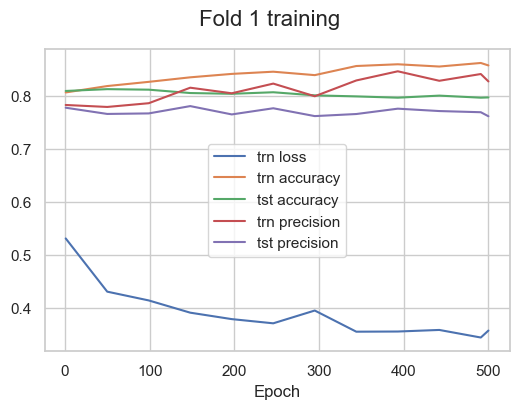

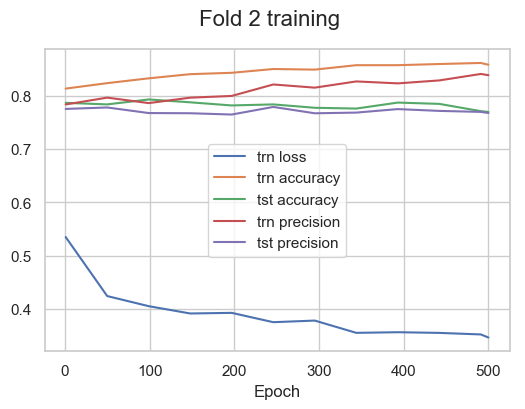

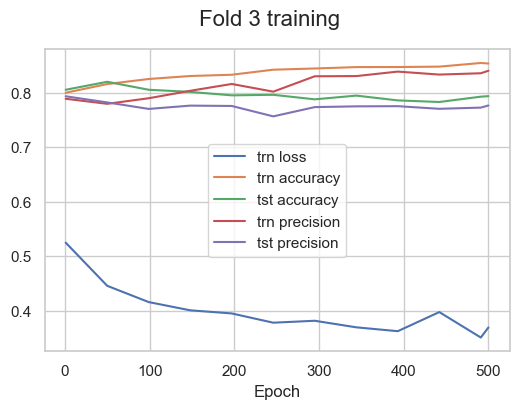

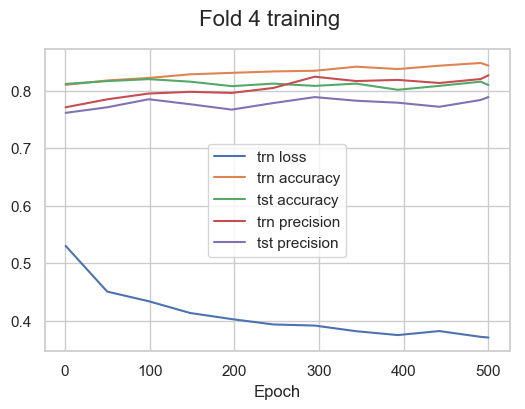

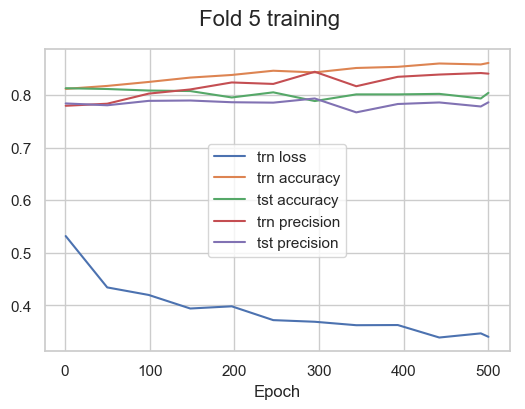

In [41]:
# Run experiment
K        = 5
epochs   = 500
lr       = 0.01
momentum = 0 # unused with Adam (default SGD 0.95)

#TOPOLOGIA 1
topology = Dict()
topology.name            = None
topology.input_size      =  folds.trn[0].shape[1]-1  # remove target column count
topology.layers          = 'inp :  64          : 32           : 2               :1'
topology.activations     = 'inp : relu         : relu         : relu            : sigmoid'
topology.initializations = 'inp : kaiming_relu : kaiming_relu : kaiming_relu    : xavier'

model = MLP(topology)
t = ETime()
model_cross_validation(model, df, K, fold_data, train_model, epochs=epochs, lr=lr, momentum=momentum, verbose=False, plot=True)
t.check()